In [49]:
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
project_path = "https://drive.google.com/drive/folders/1XsyHtdGOlPHFE9o4CX4j469yCVl0xJLa?usp=drive_link"


In [5]:
import os
os.makedirs('/content/heart_project/data', exist_ok=True)
os.makedirs('/content/heart_project/notebooks', exist_ok=True)
print("Folders created!")

Folders created!


In [6]:
!wget -P /content/heart_project/data/ https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data

# Add column names
column_names = "age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num"
with open('/content/heart_project/data/heart_disease.csv', 'w') as f:
    f.write(column_names + '\n')
    f.write(open('/content/heart_project/data/processed.cleveland.data').read())

--2025-07-22 09:39:00--  https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘/content/heart_project/data/processed.cleveland.data’

processed.cleveland     [ <=>                ]  18.03K  --.-KB/s    in 0.06s   

2025-07-22 09:39:00 (308 KB/s) - ‘/content/heart_project/data/processed.cleveland.data’ saved [18461]



In [7]:
# Check file content
with open('/content/heart_project/data/processed.cleveland.data') as f:
    print(f"First 5 lines:\n{f.readlines()[:5]}")

# Load into DataFrame (with your column names)
df = pd.read_csv('/content/heart_project/data/heart_disease.csv')
print(f"\nDataFrame shape: {df.shape}")
print(df.head())

First 5 lines:
['63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0\n', '67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2\n', '67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1\n', '37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0\n', '41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0\n']

DataFrame shape: (303, 14)
    age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0  63.0  1.0  1.0     145.0  233.0  1.0      2.0    150.0    0.0      2.3   
1  67.0  1.0  4.0     160.0  286.0  0.0      2.0    108.0    1.0      1.5   
2  67.0  1.0  4.0     120.0  229.0  0.0      2.0    129.0    1.0      2.6   
3  37.0  1.0  3.0     130.0  250.0  0.0      0.0    187.0    0.0      3.5   
4  41.0  0.0  2.0     130.0  204.0  0.0      2.0    172.0    0.0      1.4   

   slope   ca thal  num  
0    3.0  0.0  6.0    0  
1    2.0  3.0  3.0    2  
2    2.0  2.0  7.0    1  
3    3.0  0.0  3.0    0  
4    1.0  0.0  3.0    0  


#Data Quality Check and Basic Cleaning


In [8]:
print("\nMissing values:\n", df.isnull().sum())


Missing values:
 age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
num         0
dtype: int64


In [9]:
# Check for '?' placeholders
print("\nPlaceholder '?' counts:")
print((df == '?').sum())


Placeholder '?' counts:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
num         0
dtype: int64


In [10]:
# Check for '?' placeholders in numeric columns
numeric_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca', 'thal']
print("'?' counts before cleaning:")
print((df[numeric_cols] == '?').sum())

'?' counts before cleaning:
age         0
trestbps    0
chol        0
thalach     0
oldpeak     0
ca          4
thal        2
dtype: int64


In [11]:
df['ca']

,ca
0,0.0
1,3.0
2,2.0
3,0.0
4,0.0
...,...
298,0.0
299,2.0
300,1.0
301,1.0


In [12]:
df['thal']

,thal
0,6.0
1,3.0
2,7.0
3,3.0
4,3.0
...,...
298,7.0
299,7.0
300,7.0
301,3.0


#Handle Missing Values

A. For ca (Number of Major Vessels):

In [13]:
df['ca'].isnull().sum()

np.int64(0)

In [14]:
# Show rows where 'ca' is still NA after filling
print("Rows with persistent NA:")
print(df[df['ca'].isna()][['ca']])

# Check raw values before conversion
print("Unique values before cleaning:")
print(df['ca'].unique())

Rows with persistent NA:
Empty DataFrame
Columns: [ca]
Index: []
Unique values before cleaning:
['0.0' '3.0' '2.0' '1.0' '?']


In [15]:

# Replace '?' with NaN
df['ca'] = df['ca'].replace('?', np.nan)

# Convert to float
df['ca'] = df['ca'].astype(float)

# Calculate the median (now that it's numeric)
ca_median = df['ca'].median()

# Fill NaN values with the median and convert to int
df['ca'] = df['ca'].fillna(ca_median).astype(int)

assert df['ca'].isnull().sum() == 0, "NA values remain!"

In [16]:
df['ca'].isnull().sum()

np.int64(0)

In [17]:
print((df['ca'] =='?').sum())


0


In [18]:
# Convert 'thal' to numeric, coercing errors to NaN
df['thal'] = pd.to_numeric(df['thal'], errors='coerce')

# Calculate the mode of the 'thal' column (after converting '?' to NaN)
thal_mode = df['thal'].mode()[0] # .mode() returns a Series, take the first element

# Replace NaN values with the mode
df['thal'] = df['thal'].fillna(thal_mode)

# Verify that there are no more '?' or NaN values
print("Remaining '?' counts:", (df['thal'] == '?').sum())
print("Remaining NaN counts:", df['thal'].isnull().sum())

Remaining '?' counts: 0
Remaining NaN counts: 0


In [19]:
df[['ca','thal']].isnull().sum()

,0
ca,0
thal,0


In [20]:
print((df['thal'] =='?').sum())

0


In [21]:
# Confirm no missing values remain
print("Remaining missing values:\n", df.isnull().sum())

# Check data types
print("\nData types:\n", df.dtypes)

Remaining missing values:
 age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
num         0
dtype: int64

Data types:
 age         float64
sex         float64
cp          float64
trestbps    float64
chol        float64
fbs         float64
restecg     float64
thalach     float64
exang       float64
oldpeak     float64
slope       float64
ca            int64
thal        float64
num           int64
dtype: object


#

#Feature Scaling

In [22]:
numerical_cols=['age','trestbps','chol','thalach','oldpeak']
print(df[numerical_cols].describe())

              age    trestbps        chol     thalach     oldpeak
count  303.000000  303.000000  303.000000  303.000000  303.000000
mean    54.438944  131.689769  246.693069  149.607261    1.039604
std      9.038662   17.599748   51.776918   22.875003    1.161075
min     29.000000   94.000000  126.000000   71.000000    0.000000
25%     48.000000  120.000000  211.000000  133.500000    0.000000
50%     56.000000  130.000000  241.000000  153.000000    0.800000
75%     61.000000  140.000000  275.000000  166.000000    1.600000
max     77.000000  200.000000  564.000000  202.000000    6.200000


In [23]:
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

In [24]:
print("\nAfter Scaling:")
print(df[numerical_cols].describe())  # Mean ~0, Std ~1 (for StandardScaler)


After Scaling:
                age      trestbps          chol       thalach       oldpeak
count  3.030000e+02  3.030000e+02  3.030000e+02  3.030000e+02  3.030000e+02
mean  -1.465641e-18  4.426236e-16  2.345026e-16 -1.172513e-16  2.345026e-17
std    1.001654e+00  1.001654e+00  1.001654e+00  1.001654e+00  1.001654e+00
min   -2.819115e+00 -2.145037e+00 -2.334877e+00 -3.442067e+00 -8.968617e-01
25%   -7.135564e-01 -6.652997e-01 -6.905030e-01 -7.053073e-01 -8.968617e-01
50%    1.729945e-01 -9.616980e-02 -1.101357e-01  1.485618e-01 -2.067053e-01
75%    7.270888e-01  4.729601e-01  5.476139e-01  7.178079e-01  4.834512e-01
max    2.500191e+00  3.887739e+00  6.138485e+00  2.294182e+00  4.451851e+00


# Exploratory Data Analysis (EDA)

Numeric Features

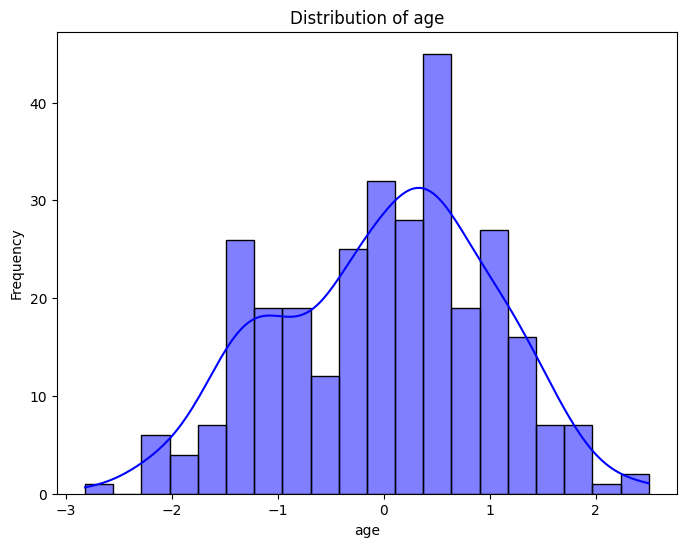

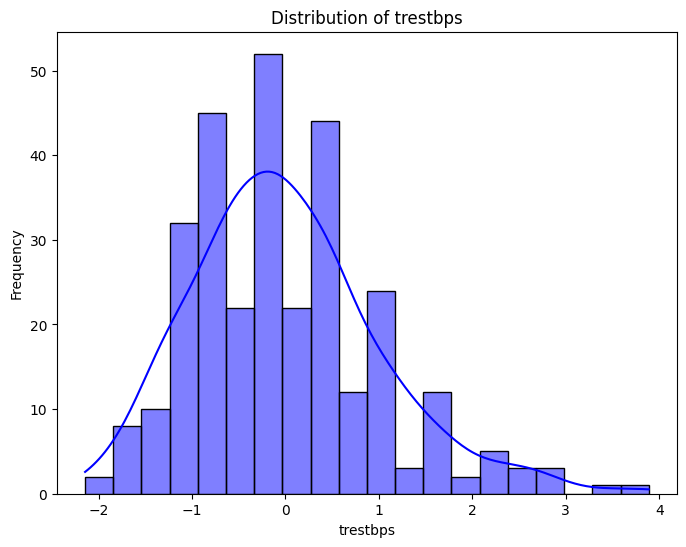

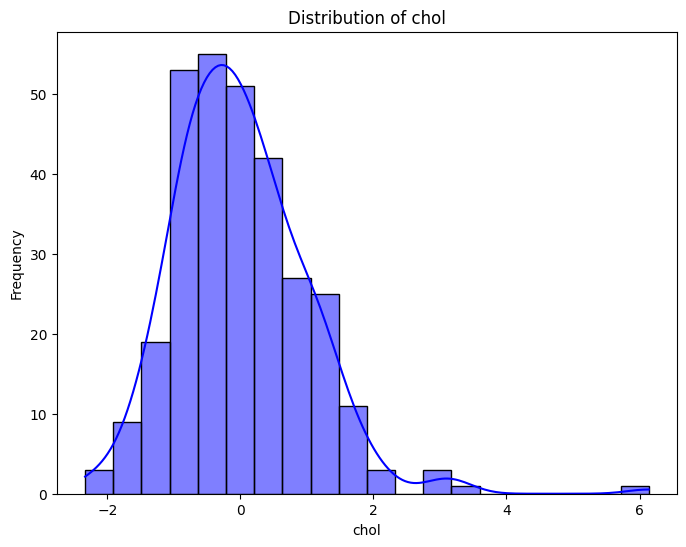

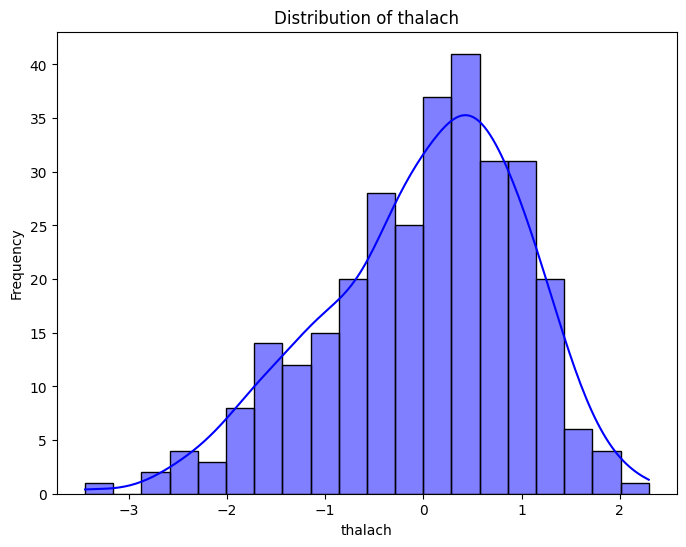

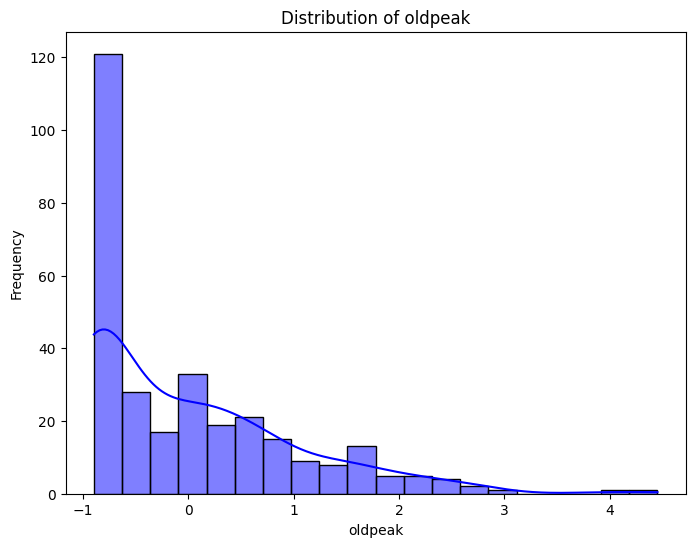

In [25]:
# Create the results directory if it doesn't exist
if not os.path.exists('results'):
    os.makedirs('results')

for col in numerical_cols:
    plt.figure(figsize=(8, 6))
    sns.histplot(df[col], kde=True, color='blue', bins=20)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.savefig(f'results/{col}_distribution.png')  # Save each plot
    plt.show()

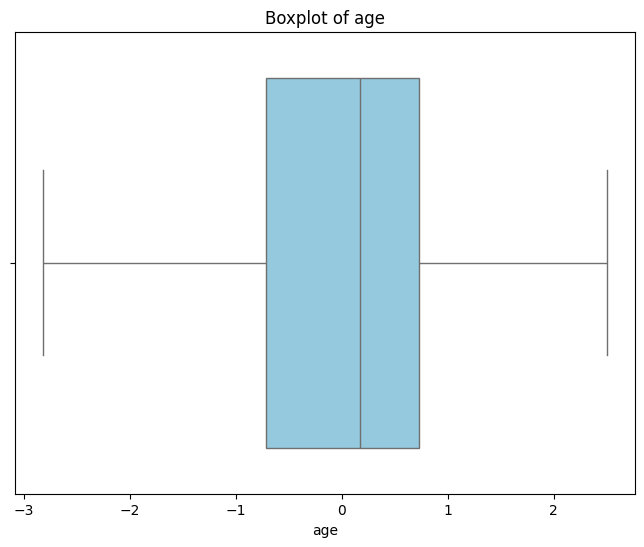

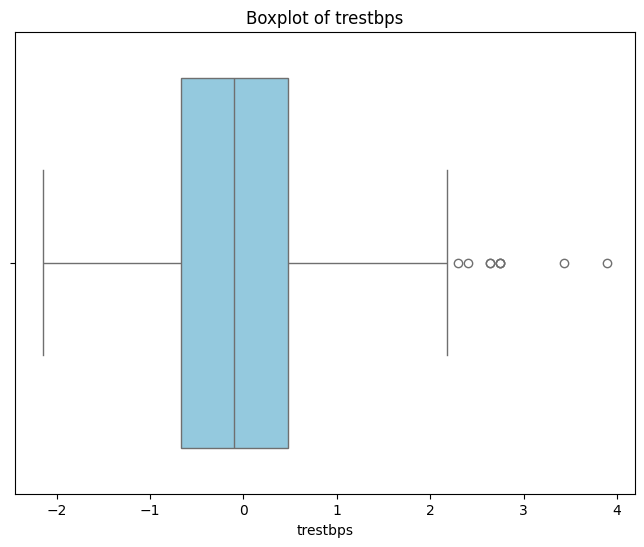

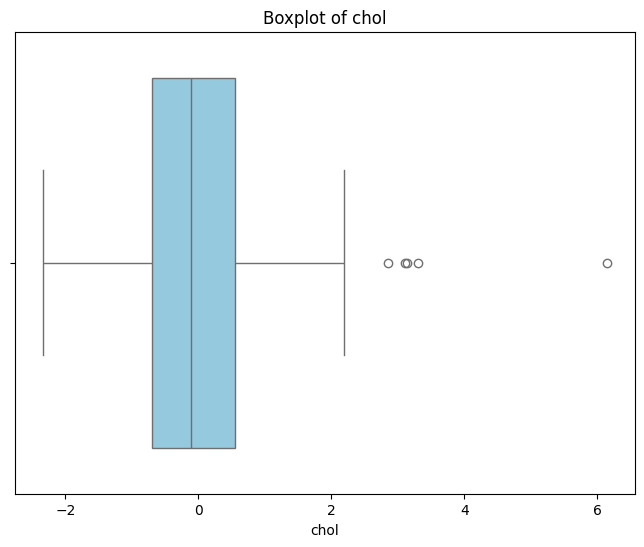

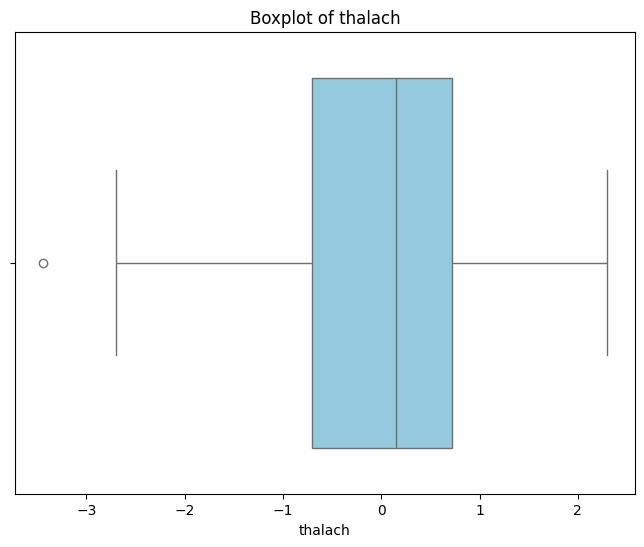

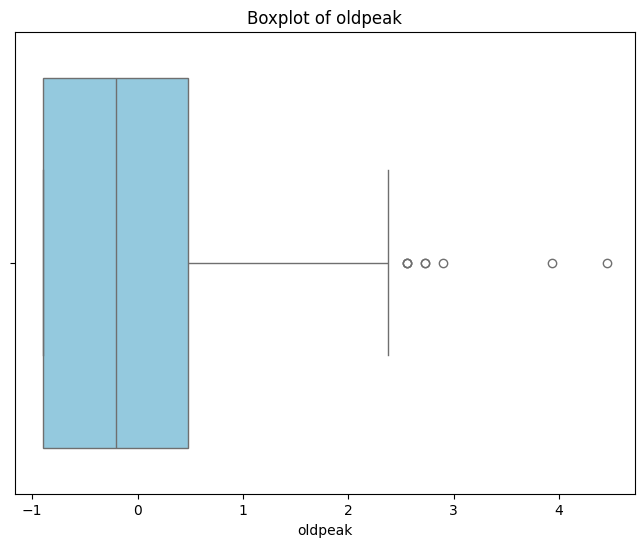

In [26]:
for col in numerical_cols:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=df[col], color='skyblue')
    plt.title(f'Boxplot of {col}')
    plt.savefig(f'results/{col}_boxplot.png')
    plt.show()

In [27]:
print("Negative values in chol:", (df['chol'] < -1).sum())
print("Negative values in oldpeak:", (df['oldpeak'] < -1).sum())
print("Negative values in trestbps:", (df['trestbps'] < 0).sum())

Negative values in chol: 36
Negative values in oldpeak: 0
Negative values in trestbps: 171


In [28]:
# Replace negatives with domain defaults
df['chol'] = df['chol'].where(df['chol'] >= 0, 126)
df['trestbps'] = df['trestbps'].where(df['trestbps'] >= 0, 120)

# Verify no more negatives
print("Remaining negatives in chol:", (df['chol'] < 0).sum())
print("Remaining negatives in trestbps:", (df['trestbps'] < 0).sum())

Remaining negatives in chol: 0
Remaining negatives in trestbps: 0


In [29]:
skewness = df[numerical_cols].skew()
print(skewness)

age        -0.209060
trestbps   -0.261092
chol       -0.193481
thalach    -0.537449
oldpeak     1.269720
dtype: float64


In [30]:

#Must-Transform Features (|Skewness| > 1)
df['oldpeak_log'] = np.log1p(df['oldpeak'])
print("oldpeak skew after log:", df['oldpeak_log'].skew())

oldpeak skew after log: -0.14500105537186256


In [31]:
# Reflect + Log to handle left skew
df['thalach_reflect_log'] = np.log1p(df['thalach'].max() - df['thalach'] + 1)

# Verify new skewness
print("thalach skew after transform:", df['thalach_reflect_log'].skew())

thalach skew after transform: -0.03589844437573674


In [32]:
skewness = df[numerical_cols].skew()
print(skewness)

age        -0.209060
trestbps   -0.261092
chol       -0.193481
thalach    -0.537449
oldpeak     1.269720
dtype: float64


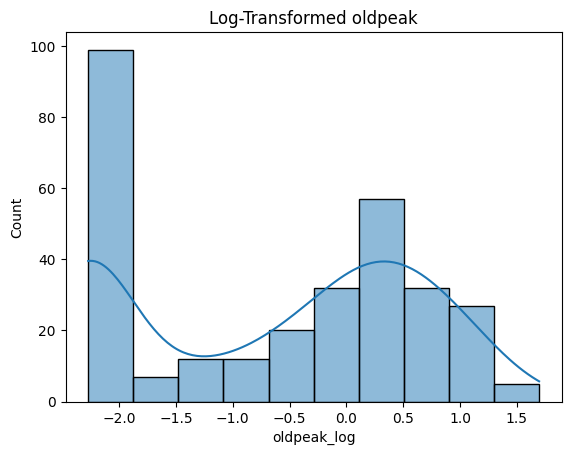

In [33]:
sns.histplot(df['oldpeak_log'], kde=True)
plt.title('Log-Transformed oldpeak')
plt.show()


In [34]:
new_cols = ['oldpeak_log', 'thalach_reflect_log']
print(df[new_cols].skew())

oldpeak_log           -0.145001
thalach_reflect_log   -0.035898
dtype: float64


In [35]:
# Reflect + Log to handle left skewness
df['thalach_reflect_log'] = np.log1p(df['thalach'].max() + 1 - df['thalach'])

Removed thalach_reflect_log column

Final Skewness:
age           -0.209060
trestbps      -0.261092
chol          -0.193481
thalach       -0.537449
oldpeak_log   -0.145001
dtype: float64


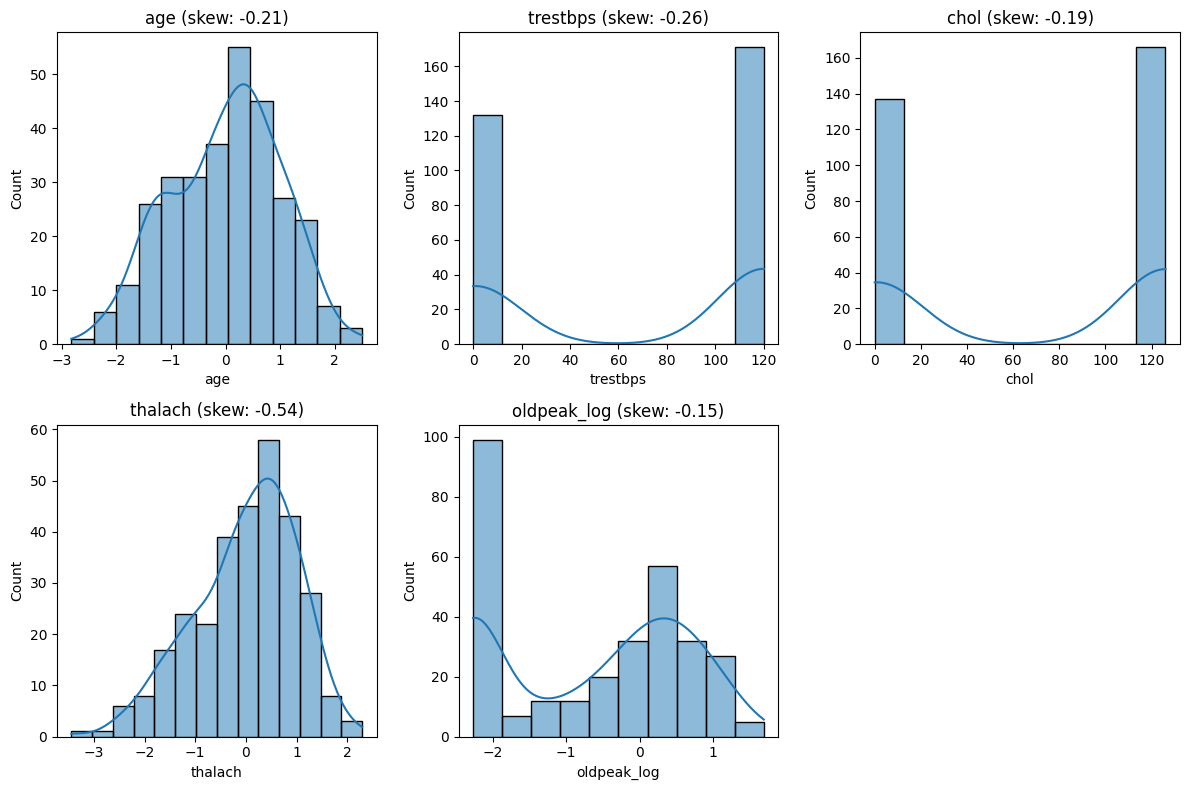


Processed data saved to: /content/heart_project/data/heart_disease_processed_final.csv


In [36]:


# 1. Keep the successful oldpeak log transformation (already done)
# df['oldpeak_log'] = np.log1p(df['oldpeak'])  # You already did this

# 2. Remove the unnecessary thalach transformation
if 'thalach_reflect_log' in df.columns:
    df.drop(columns=['thalach_reflect_log'], inplace=True)
    print("Removed thalach_reflect_log column")

# 3. Verify final skewness of columns we'll use for modeling
final_columns = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak_log']
final_skewness = df[final_columns].skew()
print("\nFinal Skewness:")
print(final_skewness)


plt.figure(figsize=(12, 8))
for i, col in enumerate(final_columns, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[col], kde=True)
    plt.title(f'{col} (skew: {final_skewness[col]:.2f})')
plt.tight_layout()
plt.show()

# 5. Save the processed dataframe (optional)
output_path = '/content/heart_project/data/heart_disease_processed_final.csv'
df.to_csv(output_path, index=False)
print(f"\nProcessed data saved to: {output_path}")

# PCA

In [37]:
df["num"] = df["num"].astype(int)
df["num"] = df["num"].apply(lambda x: 1 if x > 0 else 0)
df.rename(columns={"num": "target"}, inplace=True)


In [38]:
x=df.drop("target",axis=1)
y=df["target"]

In [39]:
pca = PCA()
X_pca = pca.fit_transform(x)

In [40]:
explained_variance = pca.explained_variance_ratio_
explained_variance

array([5.29515501e-01, 4.68881249e-01, 6.65572759e-04, 2.80614249e-04,
       1.61359743e-04, 1.24362642e-04, 1.12622653e-04, 9.14377753e-05,
       6.14724534e-05, 2.95648379e-05, 2.38012333e-05, 1.98277904e-05,
       1.78015080e-05, 1.48121316e-05])

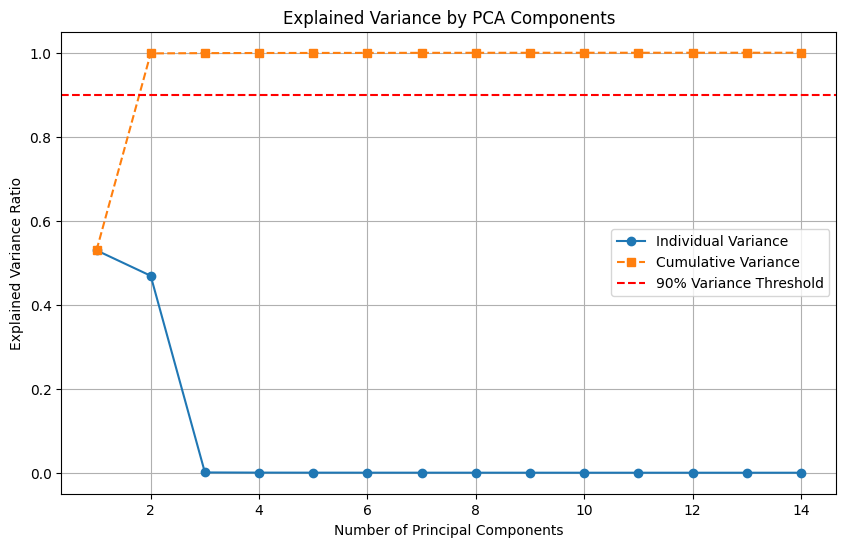

In [41]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance)+1), explained_variance, marker='o', label='Individual Variance')
plt.plot(range(1, len(explained_variance)+1), np.cumsum(explained_variance), marker='s', linestyle='--', label='Cumulative Variance')
plt.axhline(0.90, color='red', linestyle='--', label='90% Variance Threshold')
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by PCA Components')
plt.legend()
plt.grid(True)
plt.show()


# Feature Selection

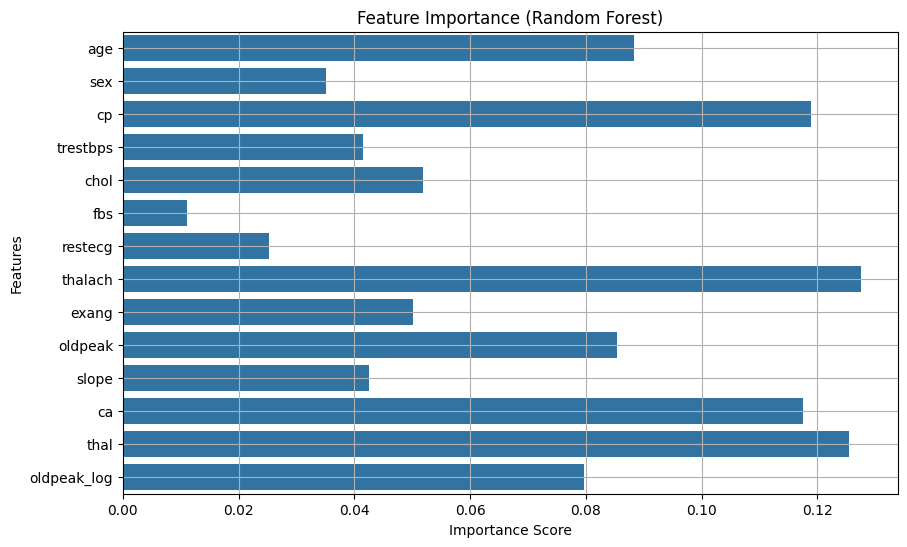

In [42]:
model = RandomForestClassifier(random_state=42)
model.fit(x, y)

importances = model.feature_importances_
features = x.columns

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=features)
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.grid(True)
plt.show()


In [43]:
selected_features = ['thalach', 'cp', 'thal', 'ca', 'oldpeak', 'oldpeak_log', 'age', 'chol']
df_top = df[selected_features + ['target']]
df_top.to_csv(f"{project_path}/data/heart_selected_features.csv", index=False)


# Supervised_Learning

In [63]:
X = df[selected_features]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

In [64]:
model_lr = LogisticRegression(max_iter=1000)
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))
print("Classification Report:\n", classification_report(y_test, y_pred_lr))

Accuracy: 0.8688524590163934
Confusion Matrix:
 [[27  6]
 [ 2 26]]
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.82      0.87        33
           1       0.81      0.93      0.87        28

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.88      0.87      0.87        61



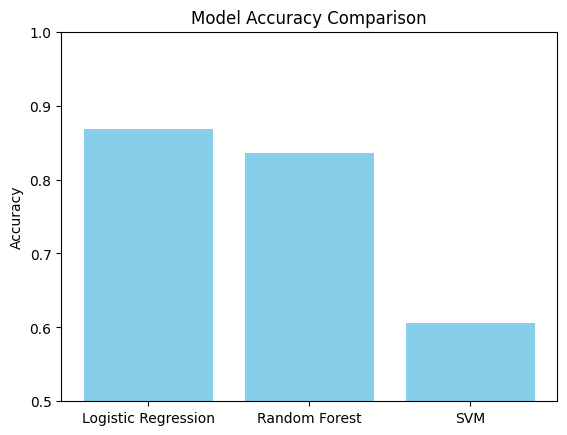

In [65]:
model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)

model_svm = SVC(random_state=42)
model_svm.fit(X_train, y_train)
y_pred_svm = model_svm.predict(X_test)

results = {
    "Logistic Regression": accuracy_score(y_test, y_pred_lr),
    "Random Forest": accuracy_score(y_test, y_pred_rf),
    "SVM": accuracy_score(y_test, y_pred_svm)
}

plt.bar(results.keys(), results.values(), color="skyblue")
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.ylim(0.5, 1.0)
plt.show()